## Problems Analysis

#### The dataset includes detailed information about each property listing, such as:
- **Price**: The asking price of the property in Euros.
- **District, City, Town**: The geographical location of the property, allowing for regional analysis.
- **Type**: The type of property (e.g., Apartment, House, Garage, Land).
- **EnergyCertificate**: The energy efficiency rating of the property, according to Portuguese energy certification standards.
- **Area Measurements**: Several columns related to the size and area of the property, including:
    - **GrossPrivateArea**: The private gross area of the property.
    - **UsableArea**: The area that can be used for living.
    - **LivingArea**: The actual livable space inside the property.
    - **LotSize**: The size of the land associated with the property.
    - **BuiltArea**: The total constructed area of the property.
- **Rooms, Bedrooms, Bathrooms, WCs**: Detailed breakdowns of the number of rooms, bedrooms, bathrooms, and water closets in the property.
- **Floor**: The floor on which the property is located.
- **Parking, Garage**: Information on parking availability and the presence of a garage.
- **Additional Features**: Whether the property includes amenities like elevators or electric car charging stations.
- **ConstructionYear**: The year the property was built.
- **PublishDate**: The date when the listing was published.

#### The dataset is suitable for a variety of analyses, including:
- **Price trends**: Understanding the relationship between location, property features, and asking prices.
- **Energy efficiency**: Investigating how energy certification impacts property values.
- **Geographical analysis**: Exploring regional differences in real estate pricing across Portugal.

## Import all the needed library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import missingno as msno
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report
import joblib
import optuna

## import the dataset

In [2]:
url = "https://raw.githubusercontent.com/suxeno/StudyDateAI-Week1-Evaluation-Dataset/refs/heads/main/portugal-housing-sample.csv"

df = pd.read_csv(url)

pd.set_option('display.max_columns', None)
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Floor,Lift,Parking,HasParking,ConstructionYear,TotalArea,GrossArea,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,55000.0,Coimbra,Figueira da Foz,Alqueidão,Land,NC,NaN,False,0.0,False,NaN,1287.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1287.0,NaN,NaN,0.0
1,289000.0,Setúbal,Montijo,Canha,House,D,NaN,False,2.0,True,1986.0,306.0,306.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,156.0,NaN,NaN,4.0
2,46500.0,Lisboa,Lourinhã,Lourinhã e Atalaia,Land,NC,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN,0.0,NaN,NaN,2880.0,NaN,0.0
3,203000.0,Porto,Vila Nova de Gaia,Vilar de Andorinho,Apartment,E,3rd Floor,True,1.0,True,1996.0,118.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,92.0,NaN,NaN,2.0
4,72500.0,Braga,Cabeceiras de Basto,"Refojos de Basto, Outeiro e Painzela",Land,NC,NaN,NaN,0.0,NaN,NaN,1954.0,NaN,NaN,False,False,False,NaN,NaN,0.0,NaN,NaN,1954.0,NaN,0.0


## EDA & Pre-processing

In [3]:
df.shape

(20000, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 20000 non-null  float64
 1   District              20000 non-null  object 
 2   City                  20000 non-null  object 
 3   Town                  19999 non-null  object 
 4   Type                  20000 non-null  object 
 5   EnergyCertificate     20000 non-null  object 
 6   Floor                 4925 non-null   object 
 7   Lift                  11874 non-null  object 
 8   Parking               19967 non-null  float64
 9   HasParking            11874 non-null  object 
 10  ConstructionYear      12965 non-null  float64
 11  TotalArea             18941 non-null  float64
 12  GrossArea             4790 non-null   float64
 13  PublishDate           2668 non-null   object 
 14  Garage                8123 non-null   object 
 15  Elevator           

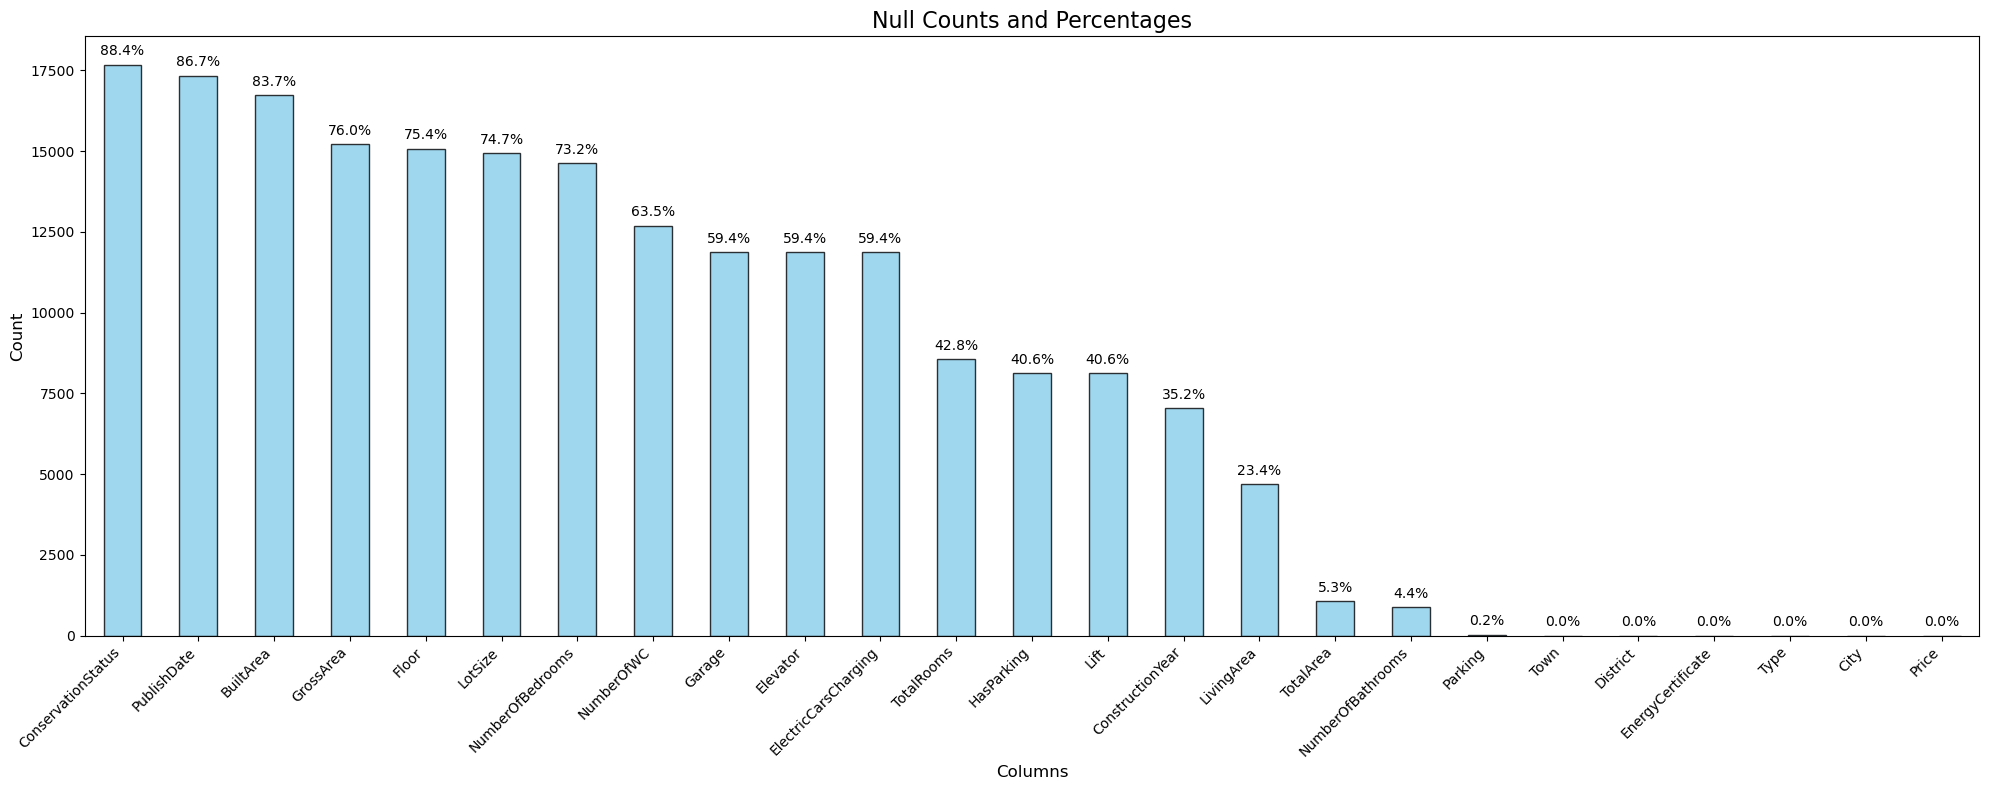

In [5]:
def visualize_nulls(df):
    # Calculate null counts and percentages
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100

    # Create a DataFrame for visualization
    null_summary = pd.DataFrame({
        'Null Count': null_counts,
        'Percentage': null_percentages
    })
    null_summary = null_summary.sort_values(by='Null Count', ascending=False)

    # Plot
    plt.figure(figsize=(20, 8))  # Increased figure size
    ax = null_summary['Null Count'].plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
    plt.title('Null Counts and Percentages', fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)

    # Add percentage labels on top of the bars
    for i, v in enumerate(null_summary['Null Count']):
        percent = null_summary['Percentage'].iloc[i]
        plt.text(i, v + (0.01 * len(df)), f"{percent:.1f}%", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_nulls(df)

Before moving on to handling all of those null values, i still wanted to see **"HOW IMPORTANT"** each x variable is so that i will not loose the important information for further regression analysis.

## Encoding variable that needed to be encoded (terms & condition applied here) 

In [6]:
df.nunique()

Price                   2130
District                  24
City                     264
Town                    1869
Type                      21
EnergyCertificate         11
Floor                     18
Lift                       2
Parking                    4
HasParking                 2
ConstructionYear         114
TotalArea               3035
GrossArea                947
PublishDate             2656
Garage                     2
Elevator                   2
ElectricCarsCharging       2
TotalRooms                33
NumberOfBedrooms          20
NumberOfWC                14
ConservationStatus         6
LivingArea              1464
LotSize                 2250
BuiltArea               1728
NumberOfBathrooms         27
dtype: int64

### Check for some variable that follows a hierarchy

In [7]:
print("Energy Certificate values: ",df['EnergyCertificate'].unique())
print("Floor values: ",df['Floor'].unique())

Energy Certificate values:  ['NC' 'D' 'E' 'F' 'C' 'A' 'A+' 'B-' 'B' 'G' 'Not available']
Floor values:  [nan '3rd Floor' '1st Floor' 'Ground Floor' '2nd Floor' '6th Floor'
 'Basement' 'Basement Level' 'Above 10th Floor' '4th Floor' '7th Floor'
 'Duplex' '9th Floor' '5th Floor' '8th Floor' 'Triplex' 'Attic'
 'Top Floor' 'Service Floor']


In [8]:
columns_to_remove = ['ConservationStatus', 'PublishDate', 'HasParking','NumberOfWC']
df.drop(columns=columns_to_remove, inplace=True)

# Columns to label encode
columns_to_encode = [
    'District', 'City', 'Town', 'Type', 
    'Lift', 'Parking', 'Garage', 'Elevator', 'ElectricCarsCharging'
]

label_encoder = LabelEncoder()

# Apply Label Encoding while ignoring NaN
for column in columns_to_encode:
    if column in df.columns:
        # Get non-null values for encoding
        non_null_values = df[column].dropna()
        
        # Fit LabelEncoder only on non-null values
        label_encoder.fit(non_null_values)
        
        # Apply encoding to non-null values and leave NaN unchanged
        df[column] = df[column].apply(lambda x: label_encoder.transform([x])[0] if pd.notnull(x) else x)

df['Floor'] = df['Floor'].map({
    'Basement Level': 0,
    'Ground Floor': 1,
    '1st Floor': 2,
    '2nd Floor': 3, 
    '3rd Floor': 4,
    '4th Floor': 5,
    '5th Floor': 6,
    '6th Floor': 7,
    '7th Floor': 8,
    '8th Floor': 9,
    '9th Floor': 10,
    'Above 10th Floor': 11,
    'Top Floor': 12,
    'Service Floor': 13,
    'Triplex': 14,
    'Duplex':15,
})

df['EnergyCertificate'] = df['EnergyCertificate'].map({
    'NC': 0,
    'D': 1,
    'E': 2,
    'F': 3,
    'C': 4,
    'A': 5,
    'A+': 6,
    'B-': 7,
    'B': 8,
    'G': 9,
    'Not available': -1 
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 20000 non-null  float64
 1   District              20000 non-null  int32  
 2   City                  20000 non-null  int32  
 3   Town                  19999 non-null  float64
 4   Type                  20000 non-null  int32  
 5   EnergyCertificate     20000 non-null  int64  
 6   Floor                 4913 non-null   float64
 7   Lift                  11874 non-null  float64
 8   Parking               19967 non-null  float64
 9   ConstructionYear      12965 non-null  float64
 10  TotalArea             18941 non-null  float64
 11  GrossArea             4790 non-null   float64
 12  Garage                8123 non-null   float64
 13  Elevator              8123 non-null   float64
 14  ElectricCarsCharging  8123 non-null   float64
 15  TotalRooms         

## Train test splitting

**Why do the train test so soon right now?**

- Performing train test split before doing any pre=processing of the train data **PREVENTS DATA LEAKAGE** 
so that the test evaluation will be accurate and are valid to be used for benchmarking models and methods

**What is DATA LEAKAGE?**
- Data leakage in simple explaination is when the test data used for benchmarking and evaluating your methods have a data point where it comes from the train data that are preprocessed so that of course the result will be good because the train and test data is similar. The model have already seen the test data before in training, its unfair and an inaccurate way to evaluate yout methods.\

> For example: if we impute the null data first before splitting it into train and test set then it will contains an imputation value where it considers the Y variable (Price), test dataset shouldnt contain any value of Y variable in nature and by having X variable where it considers the Y from train dataset it can be classified as a leakage.

In [9]:
X = df.drop(columns=['Price'])
y = df['Price']               

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train feature shape: {X_train.shape}")
print(f"Test feature shape: {X_test.shape}")
print(f"Train target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Train feature shape: (16000, 20)
Test feature shape: (4000, 20)
Train target shape: (16000,)
Test target shape: (4000,)


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 5894 to 15795
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   District              16000 non-null  int32  
 1   City                  16000 non-null  int32  
 2   Town                  15999 non-null  float64
 3   Type                  16000 non-null  int32  
 4   EnergyCertificate     16000 non-null  int64  
 5   Floor                 3939 non-null   float64
 6   Lift                  9484 non-null   float64
 7   Parking               15972 non-null  float64
 8   ConstructionYear      10347 non-null  float64
 9   TotalArea             15161 non-null  float64
 10  GrossArea             3837 non-null   float64
 11  Garage                6513 non-null   float64
 12  Elevator              6513 non-null   float64
 13  ElectricCarsCharging  6513 non-null   float64
 14  TotalRooms            9112 non-null   float64
 15  NumberOfBedrooms     

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 10650 to 15196
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   District              4000 non-null   int32  
 1   City                  4000 non-null   int32  
 2   Town                  4000 non-null   float64
 3   Type                  4000 non-null   int32  
 4   EnergyCertificate     4000 non-null   int64  
 5   Floor                 974 non-null    float64
 6   Lift                  2390 non-null   float64
 7   Parking               3995 non-null   float64
 8   ConstructionYear      2618 non-null   float64
 9   TotalArea             3780 non-null   float64
 10  GrossArea             953 non-null    float64
 11  Garage                1610 non-null   float64
 12  Elevator              1610 non-null   float64
 13  ElectricCarsCharging  1610 non-null   float64
 14  TotalRooms            2324 non-null   float64
 15  NumberOfBedrooms     

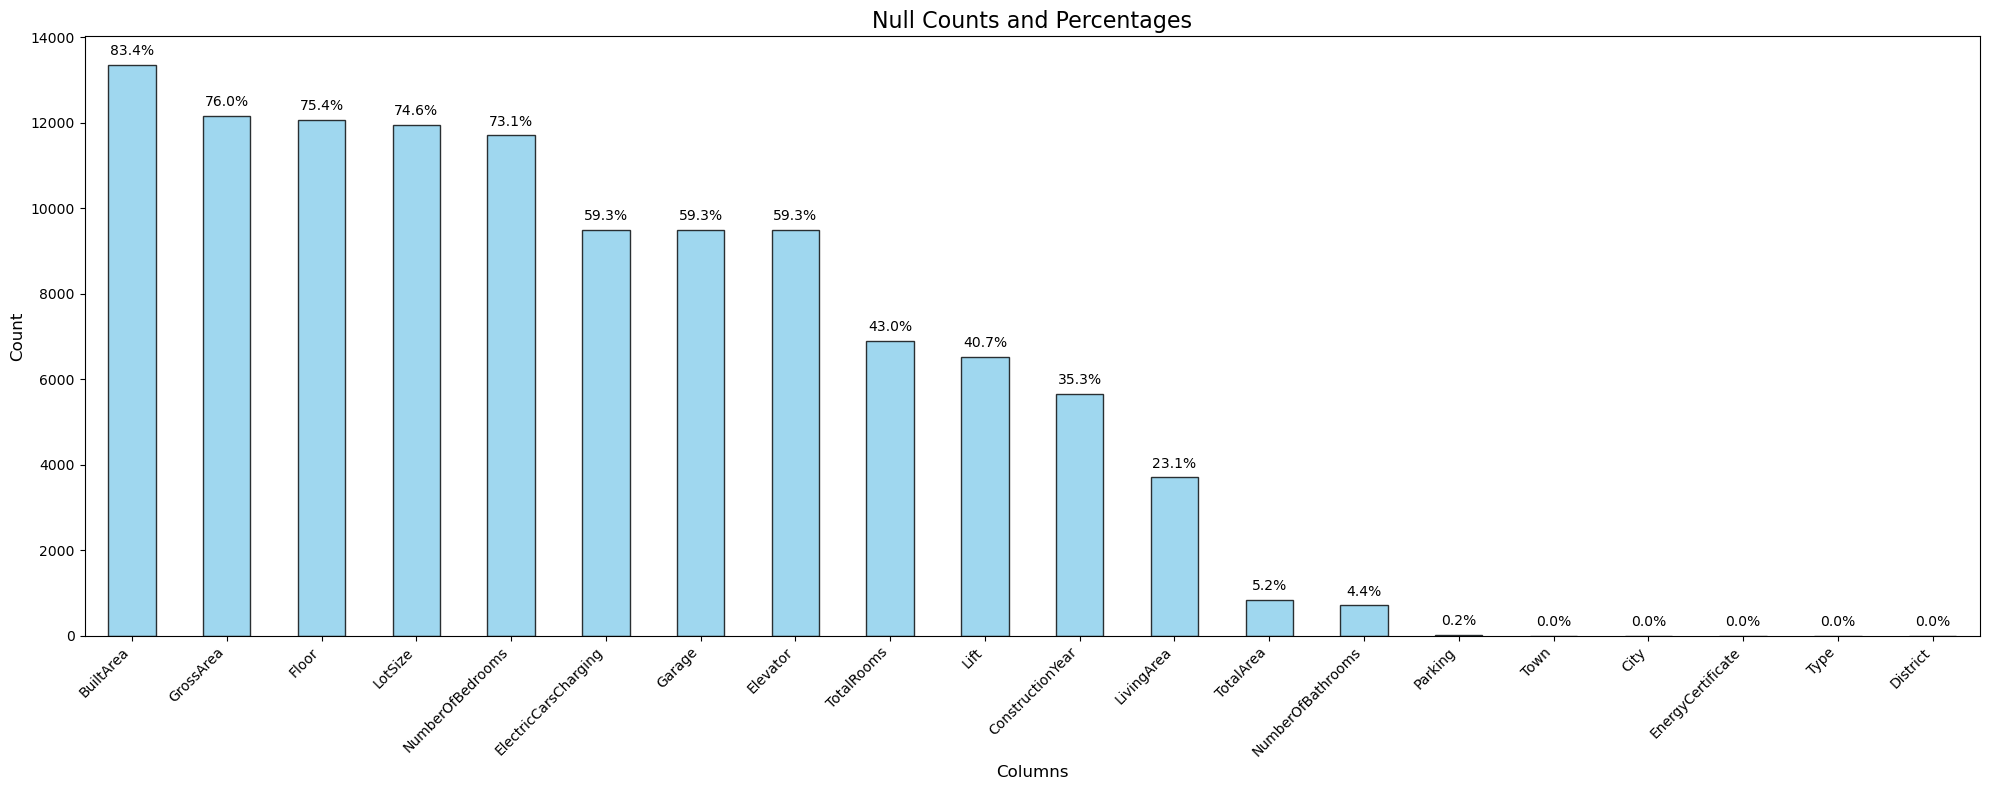

In [12]:
visualize_nulls(X_train)

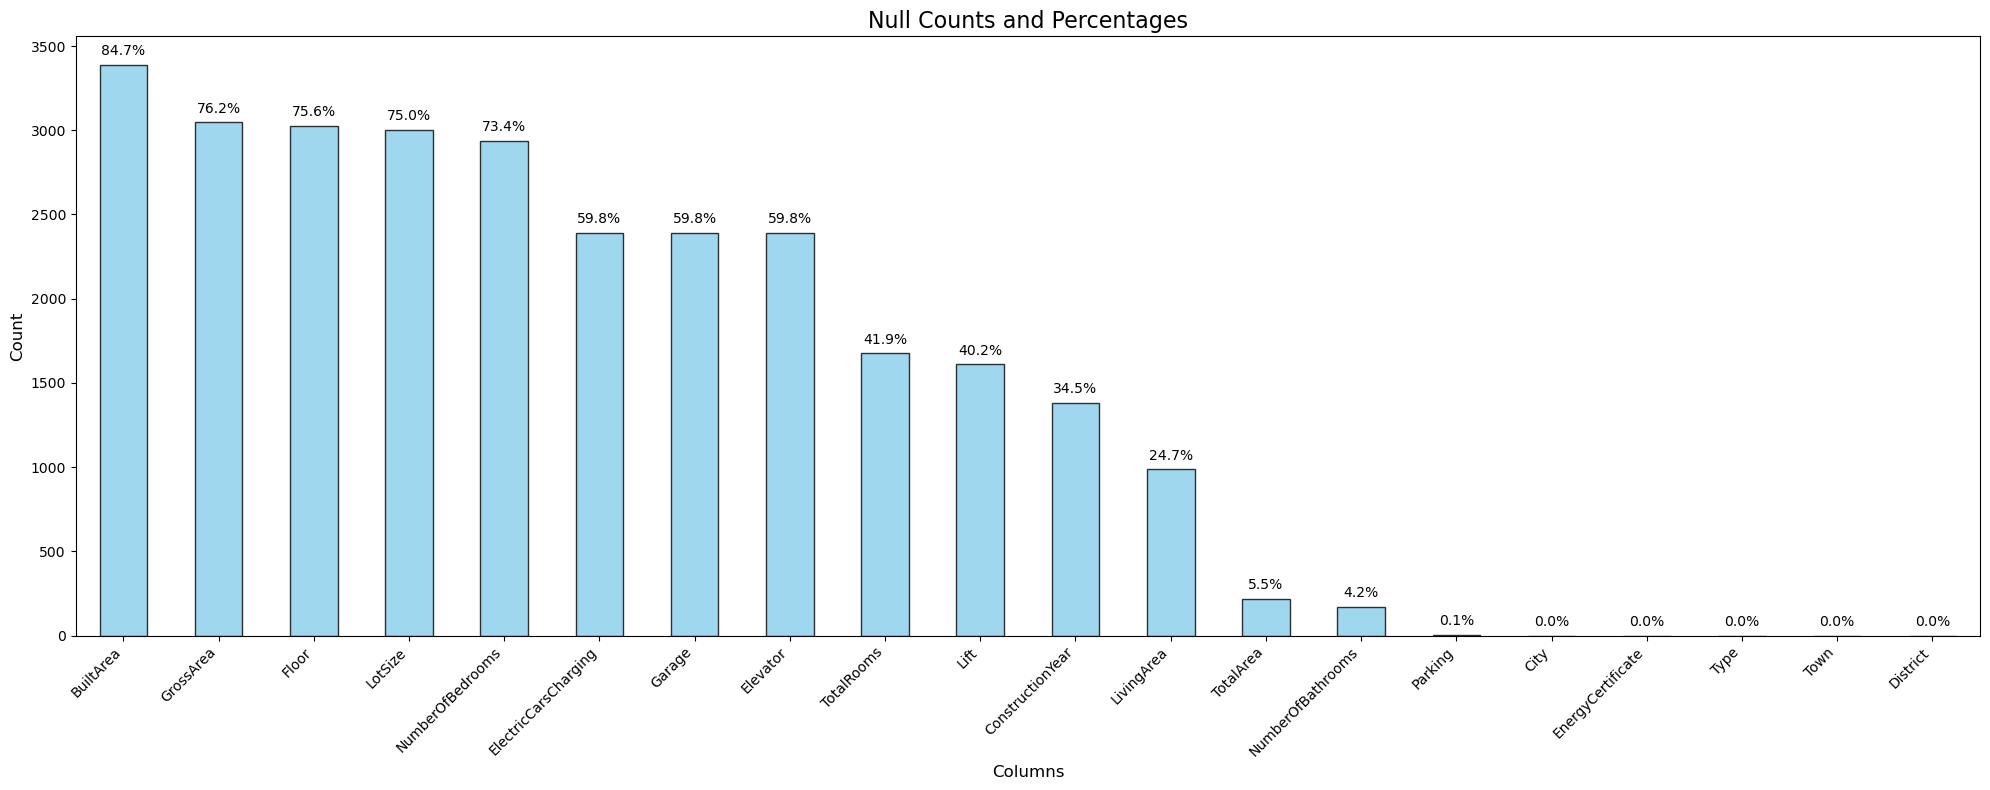

In [13]:
visualize_nulls(X_test)

## How should i handle the data fields that has >50% null values??

Maybe we can explore it first to see is there any underlying pattern we might find or any kind of clue on how to handle this further on.

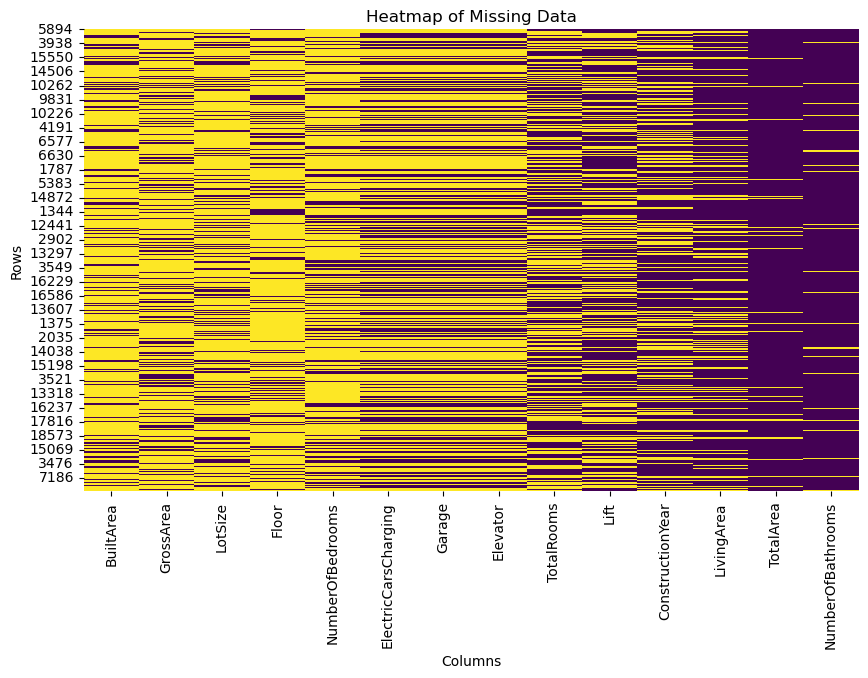

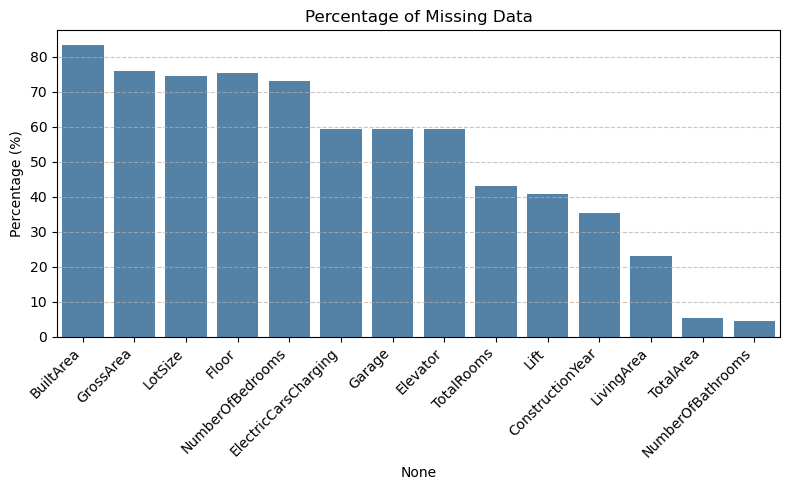

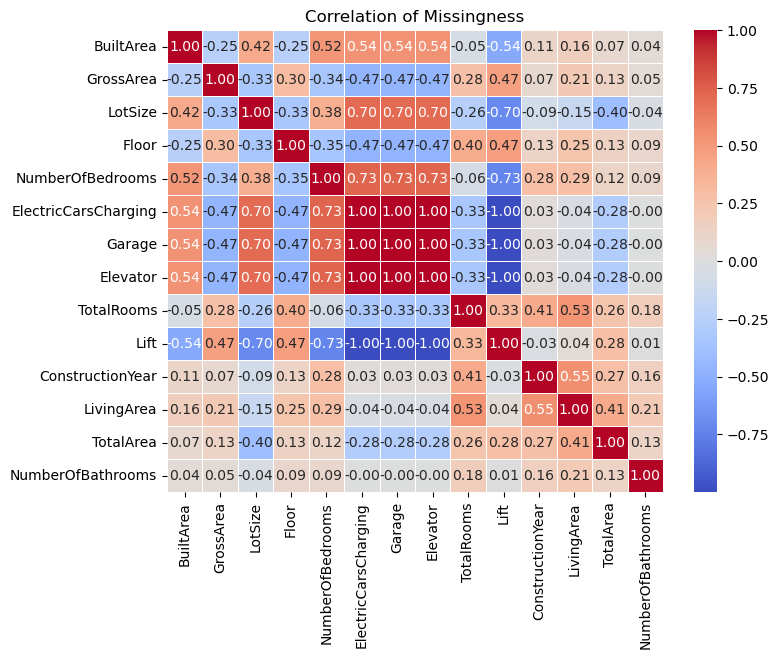

,Feature Pair,Correlation
69,"(LivingArea, Type)",0.508718
51,"(TotalRooms, Type)",0.453024
21,"(Floor, Type)",0.452455
63,"(ConstructionYear, Type)",0.335900
47,"(Elevator, Parking)",0.295972
41,"(Garage, Parking)",0.295972
35,"(ElectricCarsCharging, Parking)",0.295972
17,"(LotSize, Parking)",0.248932
27,"(NumberOfBedrooms, Type)",0.230217
75,"(TotalArea, Type)",0.178158


In [14]:
def visualize_missingness(df, columns_to_check):
    # Heatmap of missingness
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[columns_to_check].isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Data')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

    # Bar plot for missing values
    missing_counts = df[columns_to_check].isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100
    plt.figure(figsize=(8, 5))
    sns.barplot(x=missing_percentages.index, y=missing_percentages.values, color='steelblue')
    plt.title('Percentage of Missing Data')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def check_missing_correlation(df, columns_to_check):
    # Create a DataFrame indicating where values are missing
    missing_indicator = df[columns_to_check].isnull().astype(int)
    
    # Correlation heatmap for missingness
    corr_matrix = missing_indicator.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation of Missingness')
    plt.show()

    # Correlation with other features
    feature_corr = {}
    for col in columns_to_check:
        for feature in df.columns:
            if feature not in columns_to_check:
                corr = missing_indicator[col].corr(df[feature])
                feature_corr[(col, feature)] = corr
    return feature_corr

columns_missing = [
    'BuiltArea', 'GrossArea', 'LotSize', 'Floor',
    'NumberOfBedrooms', 'ElectricCarsCharging', 'Garage',
    'Elevator', 'TotalRooms', 'Lift', 'ConstructionYear',
    'LivingArea', 'TotalArea', 'NumberOfBathrooms'
]

visualize_missingness(X_train, columns_missing)

# Check correlation of missingness
correlations = check_missing_correlation(X_train, columns_missing)

# Display correlations for manual inspection
correlation_df = pd.DataFrame(correlations.items(), columns=['Feature Pair', 'Correlation'])
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)
correlation_df.head(10) 

## MCAR (missing completly at random) testing using Chi-Square test of independence

In [15]:
def test_mcar(data, columns):
    results = []

    # Create a missingness indicator DataFrame (1 for NaN, 0 for not NaN)
    missingness = data[columns].isnull().astype(int)

    # Iterate over each column to check association with other columns
    for col in columns:
        observed = missingness[col]

        # Combine missingness patterns with the rest of the data
        for other_col in data.columns:
            if other_col != col:
                # Ensure other_col is numeric or encoded for categorical data
                if data[other_col].dtype == "object":
                    encoded = LabelEncoder().fit_transform(data[other_col].astype(str))
                else:
                    encoded = data[other_col].fillna(-1)

                # Cross-tabulation between missingness and other_col
                contingency_table = pd.crosstab(observed, encoded)

                # Perform Chi-Square test
                chi2, p, dof, _ = chi2_contingency(contingency_table)

                # Compute Cramér's V
                n = contingency_table.sum().sum()
                cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

                # Append the results
                results.append({
                    'Column': col,
                    'Compared_With': other_col,
                    'Chi2_p_value': p,
                    'Cramer_V': cramer_v
                })

    results_df = pd.DataFrame(results)
    return results_df

mcar_results = test_mcar(X_train, columns_missing)

mcar_results_sorted = mcar_results.sort_values(by='Cramer_V', ascending=False)
mcar_results_sorted

,Column,Compared_With,Chi2_p_value,Cramer_V
126,Garage,ElectricCarsCharging,0.000000e+00,1.000000
145,Elevator,ElectricCarsCharging,0.000000e+00,1.000000
144,Elevator,Garage,0.000000e+00,1.000000
125,Garage,Elevator,0.000000e+00,1.000000
107,ElectricCarsCharging,Elevator,0.000000e+00,1.000000
...,...,...,...,...
137,Elevator,EnergyCertificate,1.411270e-05,0.050281
118,Garage,EnergyCertificate,1.411270e-05,0.050281
99,ElectricCarsCharging,EnergyCertificate,1.411270e-05,0.050281
202,ConstructionYear,ElectricCarsCharging,2.968515e-08,0.046547


In [16]:
# Filter variables with p-value < 0.05
significant_p_values = mcar_results[
    (mcar_results['Column'].isin(columns_missing)) & (mcar_results['Chi2_p_value'] < 0.05)
]

# Columns meeting the criteria
columns_with_low_p = significant_p_values['Column'].unique()

# Columns excluded from the criteria
columns_excluded_low_p = [col for col in columns_missing if col not in columns_with_low_p]

print("Columns with p-value < 0.05:", columns_with_low_p)
print("Columns NOT meeting p-value < 0.05 requirement:", columns_excluded_low_p)

Columns with p-value < 0.05: ['BuiltArea' 'GrossArea' 'LotSize' 'Floor' 'NumberOfBedrooms'
 'ElectricCarsCharging' 'Garage' 'Elevator' 'TotalRooms' 'Lift'
 'ConstructionYear' 'LivingArea' 'TotalArea' 'NumberOfBathrooms']
Columns NOT meeting p-value < 0.05 requirement: []


In [17]:
# Filter variables with Cramér's V > 0.3
high_cramer_v = mcar_results[
    (mcar_results['Column'].isin(columns_missing)) & (mcar_results['Cramer_V'] > 0.5)
]

# Columns meeting the criteria
columns_with_high_cramer_v = high_cramer_v['Column'].unique()

# Columns excluded from the criteria
columns_excluded_high_cramer_v = [col for col in columns_missing if col not in columns_with_high_cramer_v]

print("Columns with Cramér's V > 0.5:", columns_with_high_cramer_v)
print("Columns NOT meeting Cramér's V > 0.5 requirement:", columns_excluded_high_cramer_v)

Columns with Cramér's V > 0.5: ['BuiltArea' 'LotSize' 'Floor' 'NumberOfBedrooms' 'ElectricCarsCharging'
 'Garage' 'Elevator' 'TotalRooms' 'Lift' 'ConstructionYear' 'LivingArea'
 'TotalArea' 'NumberOfBathrooms']
Columns NOT meeting Cramér's V > 0.5 requirement: ['GrossArea']


## What can be adressed here?

That majority of columns with missing value still have a correlation with other columns existed in the data which means that they can still contains some valuable meaning inside that can be used for imputation, lest's do a quick math here:

**Highest missing value rate : &pm; 80%**, Which still leave &pm; 20% data is not null, and by lookin up how many train data we have (16.000) which means **we can still have around &pm; 3.000 data** in our pocket that are clean and non-null, and 3.000 data for me is enough to give some information for a data imputaion.

In [18]:
# Drop 'GrossArea' from the datasets
X_train = X_train.drop(columns='GrossArea')
X_test = X_test.drop(columns='GrossArea')

knn_imputer = KNNImputer(n_neighbors=3)  

# Perform imputation
X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Identify numerical columns except 'BuiltArea'
numerical_cols = X_train.select_dtypes(include=['number']).columns
if 'BuiltArea' in numerical_cols:
    numerical_cols = numerical_cols.drop('BuiltArea')  # Exclude BuiltArea from rounding bcus the float number is this is matters

X_train[numerical_cols] = X_train[numerical_cols].round().astype(int)
X_test[numerical_cols] = X_test[numerical_cols].round().astype(int)

print("Train data:\n", X_train.isnull().sum())
print("Test data:\n", X_test.isnull().sum())

Train data:
 District                0
City                    0
Town                    0
Type                    0
EnergyCertificate       0
Floor                   0
Lift                    0
Parking                 0
ConstructionYear        0
TotalArea               0
Garage                  0
Elevator                0
ElectricCarsCharging    0
TotalRooms              0
NumberOfBedrooms        0
LivingArea              0
LotSize                 0
BuiltArea               0
NumberOfBathrooms       0
dtype: int64
Test data:
 District                0
City                    0
Town                    0
Type                    0
EnergyCertificate       0
Floor                   0
Lift                    0
Parking                 0
ConstructionYear        0
TotalArea               0
Garage                  0
Elevator                0
ElectricCarsCharging    0
TotalRooms              0
NumberOfBedrooms        0
LivingArea              0
LotSize                 0
BuiltArea               0


In [19]:
df.nunique()

Price                   2130
District                  24
City                     264
Town                    1869
Type                      21
EnergyCertificate         11
Floor                     16
Lift                       2
Parking                    4
ConstructionYear         114
TotalArea               3035
GrossArea                947
Garage                     2
Elevator                   2
ElectricCarsCharging       2
TotalRooms                33
NumberOfBedrooms          20
LivingArea              1464
LotSize                 2250
BuiltArea               1728
NumberOfBathrooms         27
dtype: int64

In [20]:
X_train.nunique()

District                  24
City                     262
Town                    1785
Type                      20
EnergyCertificate         11
Floor                     16
Lift                       2
Parking                    4
ConstructionYear         112
TotalArea               2961
Garage                     2
Elevator                   2
ElectricCarsCharging       2
TotalRooms                31
NumberOfBedrooms          20
LivingArea              2193
LotSize                 3777
BuiltArea               6814
NumberOfBathrooms         26
dtype: int64

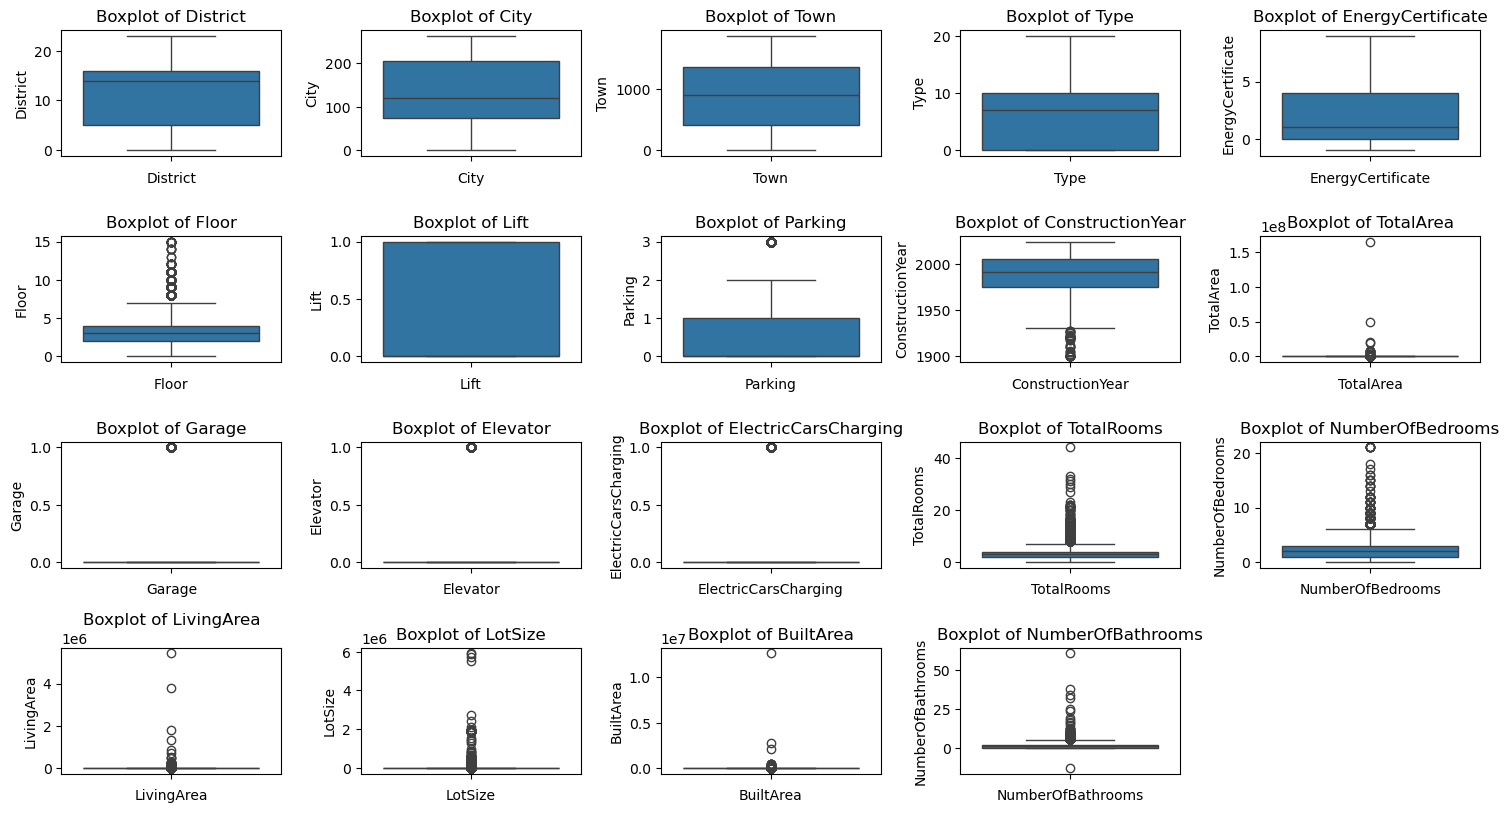

In [21]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(X_train.columns, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(data=X_train[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

I will let the outliers be it there cause it can contain useful information even tho its a minority in domain knowledge of a property business.

### Scaling before modeling is essential in regression

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [23]:
X_train.head(5)

,District,City,Town,Type,EnergyCertificate,Floor,Lift,Parking,ConstructionYear,TotalArea,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,0.086957,0.186312,0.167024,0.00,0.2,0.266667,1.0,0.0,0.862903,0.000002,0.0,0.0,0.0,0.068182,0.095238,0.000017,0.000074,0.000009,0.175676
1,0.826087,0.878327,0.925054,0.50,0.1,0.066667,0.0,0.0,0.475806,0.000041,0.0,0.0,0.0,0.000000,0.000000,0.000502,0.001113,0.000103,0.175676
2,0.608696,0.809886,0.837259,0.50,0.1,0.066667,0.0,0.0,0.669355,0.000030,0.0,0.0,0.0,0.000000,0.000000,0.000869,0.000360,0.000382,0.175676
3,0.608696,0.418251,0.579229,0.00,0.9,0.600000,1.0,0.0,0.991935,0.000002,1.0,1.0,0.0,0.045455,0.095238,0.000018,0.001366,0.000009,0.202703
4,0.608696,0.855513,0.000000,0.35,0.2,0.200000,0.0,1.0,0.862903,0.000004,0.0,0.0,0.0,0.136364,0.190476,0.000062,0.000288,0.000044,0.256757


In [24]:
# Define a list of models to train and evaluate
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Support Vector Regressor', SVR()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('XGBoost Regressor', xgb.XGBRegressor(random_state=42)),
     ('LightGBM Regressor', lgb.LGBMRegressor(random_state=42, verbosity=-1)),
    ('CatBoost Regressor', cb.CatBoostRegressor(random_state=42, verbose=0)),
    ('Extra Trees Regressor', ExtraTreesRegressor(random_state=42))
]

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=69)

# To store evaluation metrics for each model
results = []

# Cross-validation loop for each model
for model_name, model in models:
    print(f"\nEvaluating {model_name}...")
    
    # Store RMSE, MAE, MSE, and R2 for each fold
    fold_rmse = []
    fold_mae = []
    fold_mse = []
    fold_r2 = []
    
    # Cross-validation for each fold
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on validation fold
        y_pred_fold = model.predict(X_val_fold)
        
        # Evaluate performance using RMSE, MAE, MSE, and R2
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        
        # Store metrics for the current fold
        fold_rmse.append(rmse)
        fold_mae.append(mae)
        fold_mse.append(mse)
        fold_r2.append(r2)
    
    # Compute mean of metrics across all folds
    mean_rmse = np.mean(fold_rmse)
    mean_mae = np.mean(fold_mae)
    mean_mse = np.mean(fold_mse)
    mean_r2 = np.mean(fold_r2)
    
    # Store results
    results.append({
        'Model': model_name,
        'Fold RMSE': fold_rmse,
        'Fold MAE': fold_mae,
        'Fold MSE': fold_mse,
        'Fold R2': fold_r2,
        'Mean RMSE': mean_rmse,
        'Mean MAE': mean_mae,
        'Mean MSE': mean_mse,
        'Mean R2': mean_r2
    })

# Convert the results into a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the summary table for all models
print("\nSummary of Model Evaluation Across Folds:")
results_df


Evaluating Linear Regression...

Evaluating Random Forest Regressor...

Evaluating Support Vector Regressor...

Evaluating Decision Tree Regressor...

Evaluating K-Nearest Neighbors...

Evaluating XGBoost Regressor...

Evaluating LightGBM Regressor...

Evaluating CatBoost Regressor...

Evaluating Extra Trees Regressor...

Summary of Model Evaluation Across Folds:


,Model,Fold RMSE,Fold MAE,Fold MSE,Fold R2,Mean RMSE,Mean MAE,Mean MSE,Mean R2
0,Linear Regression,"[639457.8696016809, 607376.2146984775, 453445....","[258261.03427606504, 256190.85044365987, 23159...","[408906366995.5203, 368905866181.4511, 2056124...","[0.1330743602876503, 0.15699150136851237, 0.15...",775915.230001,255209.401102,6.783502e+11,-0.586206
1,Random Forest Regressor,"[584015.9406998876, 552985.5793412979, 415385....","[193496.62085925613, 185070.4266634842, 169115...","[341074618991.5746, 305793050959.43085, 172545...","[0.27688498853294674, 0.3012143085454315, 0.28...",587386.549511,182789.231805,3.717889e+11,0.269012
2,Support Vector Regressor,"[708296.989573042, 682775.743458738, 511258.97...","[278983.7536723808, 278730.411446338, 246755.7...","[501684625438.234, 466182715855.6323, 26138573...","[-0.06362556307824918, -0.06530155090595913, -...",703149.330716,271991.663826,5.237713e+11,-0.061744
3,Decision Tree Regressor,"[1282276.5153458086, 1079157.6822182925, 62381...","[259798.91820907738, 248792.85843263887, 22020...","[1644233061807.3894, 1164581303090.757, 389141...","[-2.4859515869538473, -1.661253251445867, -0.6...",924520.046954,239212.749065,9.167095e+11,-1.006200
4,K-Nearest Neighbors,"[659548.7262813828, 650915.9232057395, 491747....","[251310.379130625, 250363.260881875, 225097.96...","[435004522339.3945, 423691539082.7801, 2418159...","[0.07774345364748003, 0.031797537018949606, 0....",665320.589850,242806.483833,4.690450e+11,0.048699
5,XGBoost Regressor,"[521967.5806779452, 552787.567308936, 454477.3...","[185042.09138524815, 188752.1198872923, 173012...","[272450155278.78726, 305574094571.33154, 20654...","[0.4223762596551126, 0.30171465866972746, 0.14...",576797.037129,183233.637784,3.552879e+11,0.282070
6,LightGBM Regressor,"[511367.18685787136, 489471.73488503124, 39149...","[189020.18815991082, 190184.45371151206, 16937...","[261496399794.93314, 239582579251.3623, 153265...","[0.44559940374520435, 0.4525157528028878, 0.36...",542743.654964,184814.387052,3.242862e+11,0.380991
7,CatBoost Regressor,"[506340.0046305998, 498051.187783758, 415090.4...","[181374.27844645336, 183145.6943607088, 166629...","[256380200289.31583, 248054985652.81213, 17230...","[0.4564462989938467, 0.43315495847827545, 0.28...",546516.761120,178515.512191,3.261040e+11,0.366714
8,Extra Trees Regressor,"[538794.002668818, 597025.0004757922, 404252.1...","[196884.75831418272, 189182.94096205384, 16903...","[290298977311.8862, 356438851193.1196, 1634198...","[0.3845348301541489, 0.18548061078961375, 0.32...",592577.213274,187276.893423,3.772608e+11,0.250627


In [25]:
# Now, train the final model on the entire training data (X_train) and evaluate on X_test
final_results = []
for model_name, model in models:
    print(f"\nTraining final {model_name} on all training data and evaluating on X_test...")
    
    # Train the final model on the entire training data
    model.fit(X_train, y_train)
    
    # Predict on the test data (X_test)
    y_pred_test = model.predict(X_test)
    
    # Evaluate the final model on the test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    final_results.append({
        'Model': model_name,
        'Test RMSE': rmse_test,
        'Test MAE': mae_test,
        'Test MSE': mse_test,
        'Test R2': r2_test
    })

# Convert the final results into a DataFrame for easy viewing
final_results_df = pd.DataFrame(final_results)

# Display the final evaluation summary for all models on X_test
print("\nFinal Evaluation on Test Set:")
final_results_df


Training final Linear Regression on all training data and evaluating on X_test...

Training final Random Forest Regressor on all training data and evaluating on X_test...

Training final Support Vector Regressor on all training data and evaluating on X_test...

Training final Decision Tree Regressor on all training data and evaluating on X_test...

Training final K-Nearest Neighbors on all training data and evaluating on X_test...

Training final XGBoost Regressor on all training data and evaluating on X_test...

Training final LightGBM Regressor on all training data and evaluating on X_test...

Training final CatBoost Regressor on all training data and evaluating on X_test...

Training final Extra Trees Regressor on all training data and evaluating on X_test...

Final Evaluation on Test Set:


,Model,Test RMSE,Test MAE,Test MSE,Test R2
0,Linear Regression,1.009760e+06,254962.724598,1.019614e+12,-2.028634
1,Random Forest Regressor,4.590658e+05,174402.268527,2.107414e+11,0.374020
2,Support Vector Regressor,5.996741e+05,259150.259447,3.596090e+11,-0.068173
3,Decision Tree Regressor,6.450934e+05,228961.292560,4.161454e+11,-0.236107
4,K-Nearest Neighbors,5.460164e+05,229567.011949,2.981339e+11,0.114431
5,XGBoost Regressor,4.238902e+05,172914.352320,1.796829e+11,0.466275
6,LightGBM Regressor,4.369260e+05,175706.972284,1.909044e+11,0.432943
7,CatBoost Regressor,4.229202e+05,165639.909440,1.788615e+11,0.468715
8,Extra Trees Regressor,4.418825e+05,173160.525931,1.952602e+11,0.420005


In [28]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'thread_count': -1, 
        'task_type': 'CPU', 
    }

    # Initialize and train CatBoostRegressor
    model = cb.CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Evaluate on the validation set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Best parameters and score
print("Best parameters:", study.best_params)
print("Best MSE:", study.best_value)

[I 2024-12-01 14:31:32,239] A new study created in memory with name: no-name-adf65206-cca4-41f5-acc5-683aba425233


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-01 14:31:33,919] Trial 0 finished with value: 325673516581.68475 and parameters: {'iterations': 536, 'learning_rate': 0.0002073211548569797, 'depth': 4, 'l2_leaf_reg': 1.3680071762581645, 'random_strength': 0.0481822410285383, 'bagging_temperature': 0.13338975471263026, 'border_count': 47}. Best is trial 0 with value: 325673516581.68475.
[I 2024-12-01 14:31:58,665] Trial 1 finished with value: 181042154517.91412 and parameters: {'iterations': 779, 'learning_rate': 0.03431324994287836, 'depth': 11, 'l2_leaf_reg': 5.028175001486335, 'random_strength': 0.9527475678622408, 'bagging_temperature': 0.8312932647738067, 'border_count': 203}. Best is trial 1 with value: 181042154517.91412.
[I 2024-12-01 14:32:00,308] Trial 2 finished with value: 321414690092.2236 and parameters: {'iterations': 324, 'learning_rate': 0.00036363228607853767, 'depth': 8, 'l2_leaf_reg': 0.03126084929850204, 'random_strength': 0.9617368241452635, 'bagging_temperature': 0.0571844798187956, 'border_count': 58

In [29]:
# Use the best parameters from Optuna
best_params = study.best_params
model = cb.CatBoostRegressor(**best_params, verbose=0)

# Train the final model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)

# Print the metrics
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test MSE: 148229042418.6188
Test RMSE: 385005.2499
Test MAE: 155567.6257
